In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
import random

from scipy import stats as sc
from scipy.stats import lognorm, norm

from sklearn.model_selection import train_test_split

from colorama import Fore, Style
from termcolor import colored

from UQpy import surrogates, sensitivity, distributions
from UQpy.surrogates import PolynomialChaosExpansion, TotalDegreeBasis
from UQpy.sensitivity import PceSensitivity
from UQpy.distributions import Uniform, Normal, Lognormal, JointIndependent
from UQpy.surrogates.polynomial_chaos.polynomials.baseclass.Polynomials import Polynomials
from UQpy.surrogates.polynomial_chaos.regressions.LeastSquareRegression import LeastSquareRegression

In [16]:
#Nastaveni kodu
nsim=200 #Pocet simulci se kterimi PCE pracuje
target_error = 1
CheckOverfitting = True
least_squares = LeastSquareRegression()

In [18]:
# Načtení dat
df = pd.read_csv('Oakwood(3).csv')
df.head()
print(df.shape)
df_split = df.iloc[:, 0].str.split(";", expand=True)
input_names = [
    "Ec", "Rel", "Erat_1", "E50_1", "c_1", "phi_1", "k0_1",
    "Erat_2", "E50_2", "c_2", "phi_2", "k0_2"
]
output_names = [
    "U_251_1", "U_260_1", "U_281_1", "U_289_1", "U_295_1", "U_403_1",
    "U_251_2", "U_260_2", "U_281_2", "U_289_2", "U_295_2", "U_403_2",
    "U_320_19.2", "U_318_19.2", "U_316_19.2", "U_315_19.2", "U_314_19.2",
    "U_313_19.2", "U_312_19.2", "U_311_19.2", "U_310_19.2", "U_308_19.2", "U_306_19.2"
]
all_names = input_names + output_names
df_split.columns = all_names
df_float = df_split.astype(float)
df_float

(1000, 1)


,Ec,Rel,Erat_1,E50_1,c_1,phi_1,k0_1,Erat_2,E50_2,c_2,...,U_318_19.2,U_316_19.2,U_315_19.2,U_314_19.2,U_313_19.2,U_312_19.2,U_311_19.2,U_310_19.2,U_308_19.2,U_306_19.2
0,12.5,52.85,2.21,73.9,21.6,29.7,0.619,2.79,135.0,4.29,...,-0.003065,-0.010106,-0.016012,-0.023664,-0.027770,-0.024399,-0.017712,-0.011355,-0.003575,-0.000302
1,13.5,46.30,2.37,59.6,30.9,30.5,0.983,2.02,140.0,3.77,...,-0.003406,-0.011466,-0.017314,-0.025440,-0.029641,-0.026037,-0.018946,-0.012234,-0.003320,-0.000015
2,12.4,43.72,2.96,76.7,31.1,30.0,1.000,2.84,138.0,6.48,...,-0.003434,-0.010287,-0.015514,-0.022710,-0.026571,-0.023541,-0.017364,-0.011221,-0.003486,-0.000451
3,13.6,37.05,2.41,63.7,23.4,30.6,1.050,2.42,124.0,4.09,...,-0.003681,-0.010214,-0.015210,-0.022035,-0.025780,-0.022948,-0.017115,-0.011134,-0.003708,-0.000712
4,13.6,65.04,2.32,63.5,32.8,32.1,0.995,2.99,132.0,5.64,...,-0.003319,-0.009898,-0.014986,-0.021961,-0.025762,-0.022843,-0.016860,-0.010872,-0.003411,-0.000469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,14.4,52.39,2.24,64.4,30.3,29.8,1.020,2.05,140.0,4.55,...,-0.003371,-0.010174,-0.015324,-0.022459,-0.026305,-0.023269,-0.017118,-0.011039,-0.003353,-0.000399
996,15.1,30.34,2.71,64.6,34.3,32.5,0.715,2.40,135.0,3.75,...,-0.002791,-0.010587,-0.016700,-0.024831,-0.029140,-0.025446,-0.018286,-0.011634,-0.003058,0.000176
997,12.6,43.70,2.45,59.9,30.9,28.9,0.935,2.64,137.0,5.58,...,-0.003225,-0.011361,-0.017311,-0.025536,-0.029795,-0.026140,-0.018957,-0.012191,-0.003219,0.000063
998,12.1,32.16,2.48,56.6,34.3,31.9,0.906,2.49,141.0,6.03,...,-0.003326,-0.010511,-0.016035,-0.023618,-0.027622,-0.024357,-0.017809,-0.011473,-0.003437,-0.000295


In [20]:
input_distributions = [
    # Obecné parametry
    Normal(loc=13, scale=1),         # Econc (GPa) - nyní přímo normální rozdělení
    Uniform(loc=30, scale=40),       # Relaxation % (30-70%)
    
    # Vrstva zeminy 1
    Uniform(loc=2, scale=1),         # E/E50 (2-3)
    Normal(loc=65, scale=5),         # E50 (kPa)
    Normal(loc=30, scale=5),         # c' (kPa)
    Normal(loc=30, scale=1),         # φ' (deg)
    Uniform(loc=0.6, scale=0.5),    # ko (0.6-1.1)
    
    # Vrstva zeminy 2
    Uniform(loc=2, scale=1),         # E/E50 (2-3)
    Normal(loc=130, scale=10),       # E50 (kPa)
    Normal(loc=5, scale=1),          # c' (kPa)
    Normal(loc=42, scale=1),         # φ' (deg)
    Uniform(loc=0.45, scale=0.2)     # ko (0.45-0.65)
]
joint = JointIndependent(marginals=input_distributions)

In [22]:
df_float = df_float.apply(pd.to_numeric, errors='coerce')
mean_values = []
std_deviations = []
for column in df_float.columns:
    values = df_float[column]
    
    # Výpočet průměru a směrodatné odchylky
    mean_val = np.mean(values)
    std_dev = np.std(values, ddof=1) 
    mean_values.append(mean_val)
    std_deviations.append(std_dev)
results_df = pd.DataFrame({
    'Sloupec': df_float.columns,
    'Průměr': mean_values,
    'Směrodatná odchylka': std_deviations
})
print(results_df)

       Sloupec        Průměr  Směrodatná odchylka
0           Ec  1.300050e+01             0.999755
1          Rel  4.999998e+01            11.552588
2       Erat_1  2.500000e+00             0.288848
3        E50_1  6.499840e+01             5.008615
4          c_1  3.000010e+01             5.004932
5        phi_1  3.000060e+01             1.000530
6         k0_1  8.500000e-01             0.144422
7       Erat_2  2.500000e+00             0.288848
8        E50_2  1.299915e+02            10.018494
9          c_2  4.998302e+00             1.004635
10       phi_2  4.200000e+01             1.001470
11        k0_2  5.499970e-01             0.057777
12     U_251_1  5.000000e-07             0.000016
13     U_260_1  2.467500e-03             0.000147
14     U_281_1 -3.076528e-03             0.000980
15     U_289_1 -9.189029e-03             0.000799
16     U_295_1 -4.458262e-03             0.000987
17     U_403_1 -6.868428e-03             0.000839
18     U_251_2 -3.403418e-03             0.000698


In [24]:
# Rozdeleni souboru na dva vstupy a vystupy
df = df_float
first_u_col = df.columns[df.columns.str.startswith('U_')][0]
param_columns = df.columns[:df.columns.get_loc(first_u_col)]
df_params = df[param_columns]
df_u = df.loc[:, first_u_col:] 
 
df_params = df_params.astype(float) # Hodnoty vstupu pouze
df_u = df_u.astype(float) # Hodnoty vystupu pouze
#print(df_params)
#print(df_u.head)

#df_params.to_csv('parameters.csv', index=False)
#df_u.to_csv('u_values.csv', index=False)


Opakování 1/2
  Počet simulací: 70
Opakování 2/2


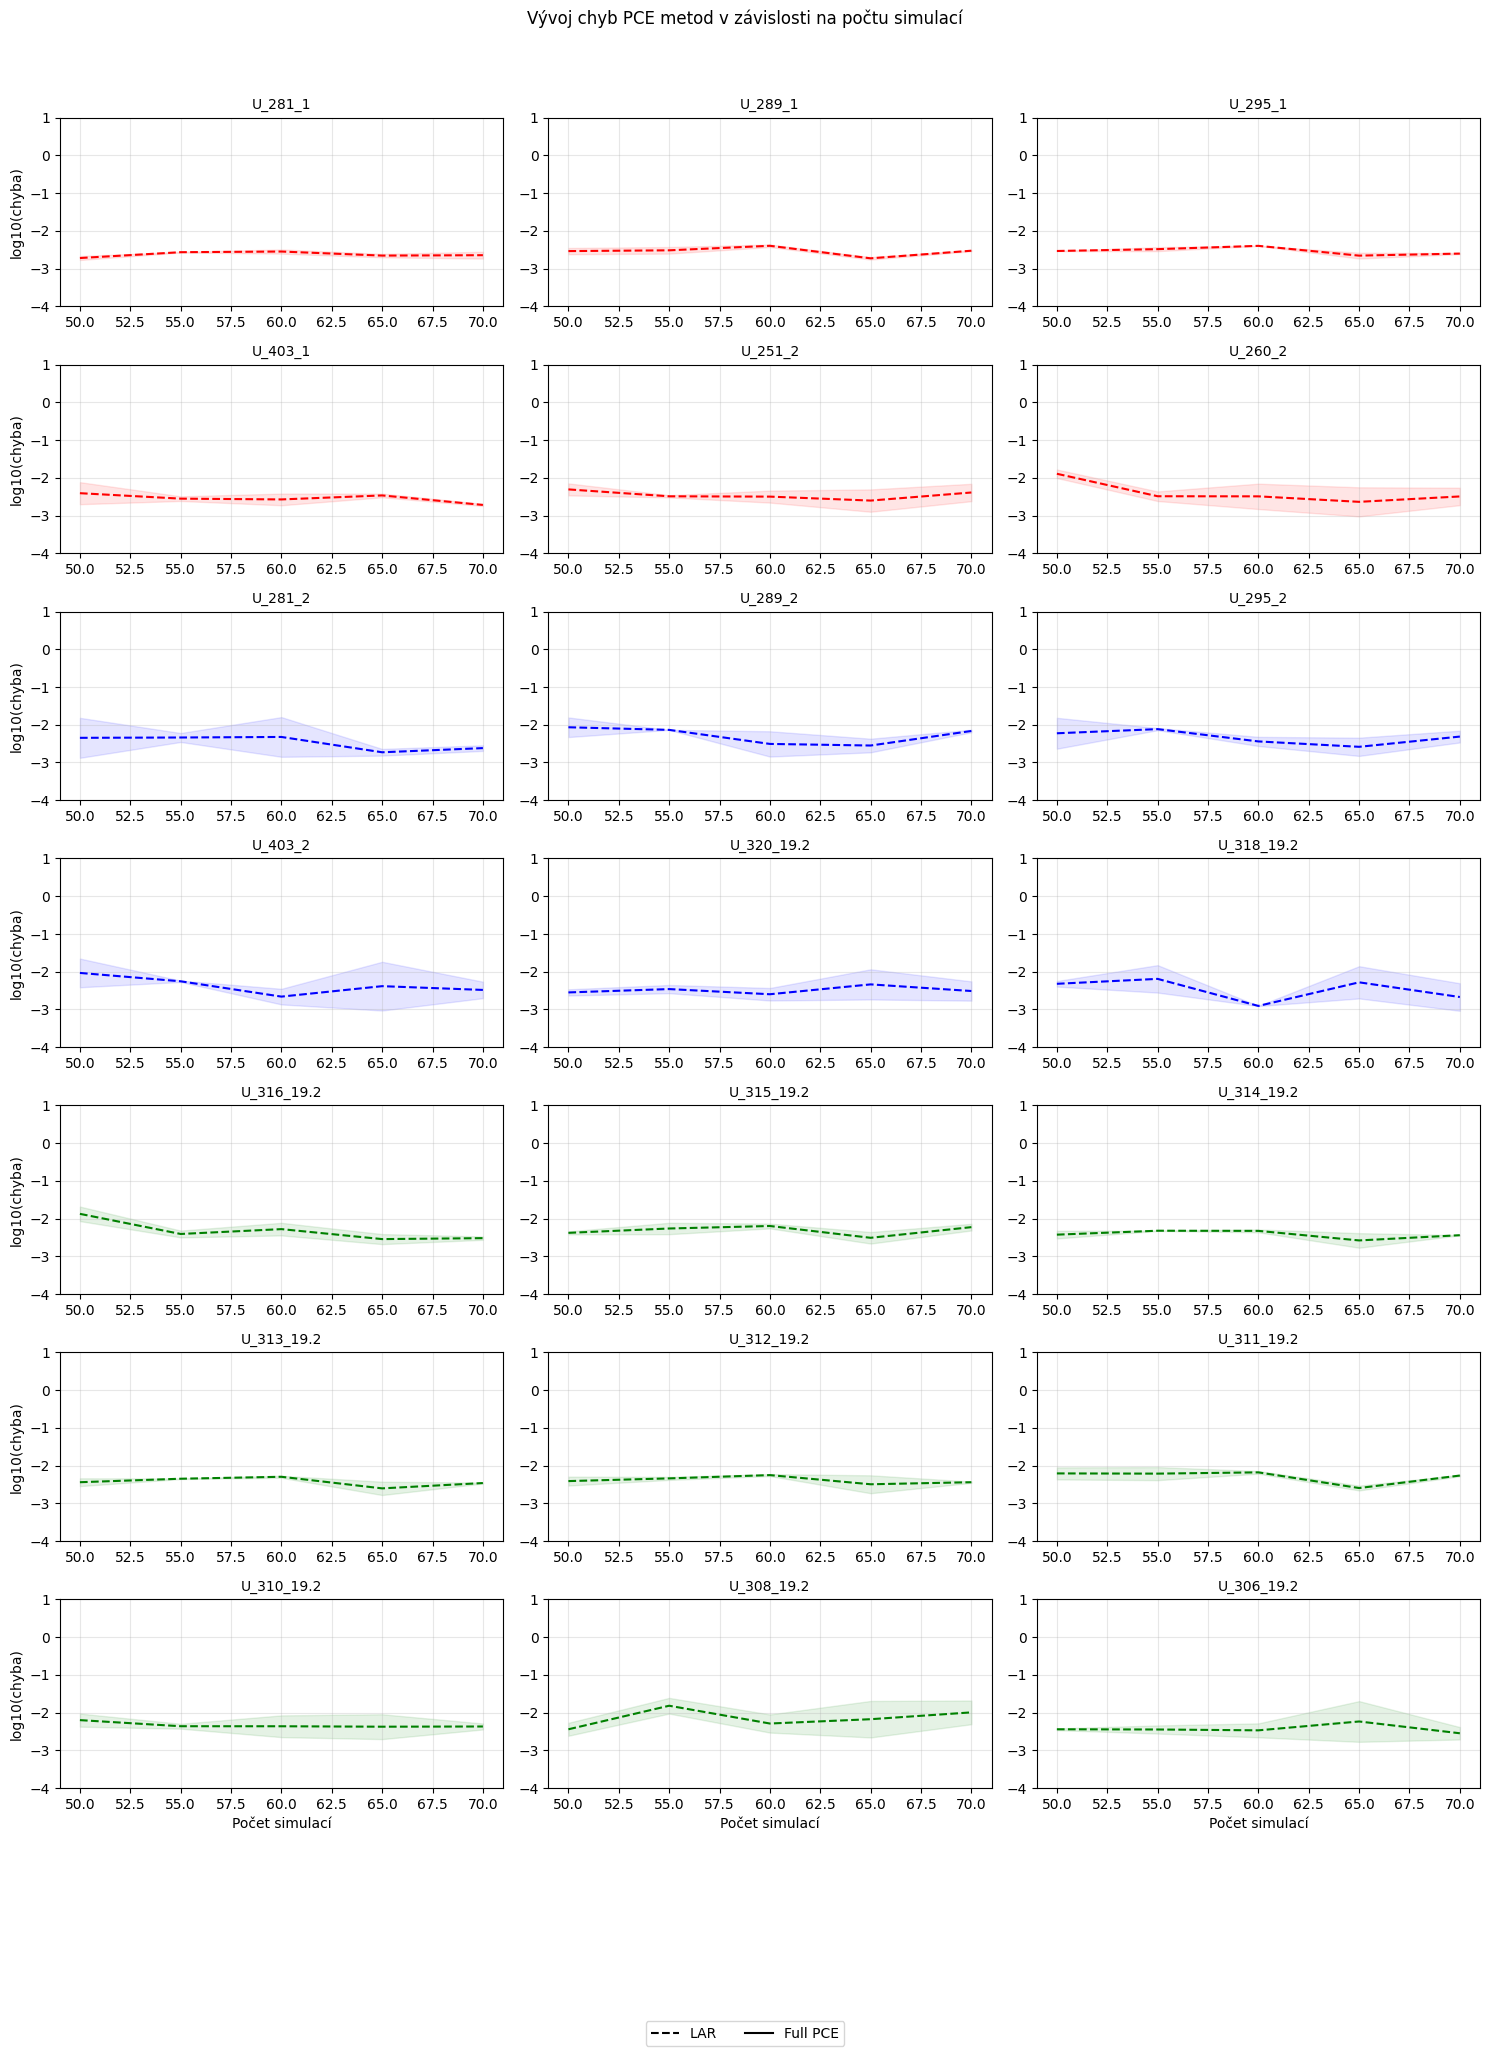

In [67]:
# Upravený kód pro vykreslování chyb PCE metod

def logplot(vals):
    """Upravená funkce pro logplot s lepším ošetřením vstupů"""
    vals = np.array(vals)
    vals = vals[~np.isnan(vals)]  # Odstranění NaN hodnot
    if len(vals) == 0:
        return np.nan, np.nan, np.nan
    
    with np.errstate(divide='ignore'):  # Ignorovat varování pro log(0)
        log_vals = np.log10(vals)
        log_vals[~np.isfinite(log_vals)] = -10  # Nahradit -inf za -10
    
    if len(log_vals) == 0:
        return np.nan, np.nan, np.nan
        
    delta = np.std(log_vals)
    means = np.mean(log_vals)
    maxy = means + delta
    miny = means - delta
    
    return means, maxy, miny

# Příprava dat pro grafy
n_repeats = 2
sim_points = [5*i for i in range(10,15 )]  # [5, 10, ..., 100]
output_cols = [col for col in df_u.columns if col not in ['U_260_1', 'U_251_1']]  # Bez problematických sloupců

# Inicializace struktur pro výsledky
results = {
    'LAR_LOO': np.zeros((n_repeats, len(sim_points), len(output_cols))),
    'Full_LOO': np.zeros((n_repeats, len(sim_points), len(output_cols))),
    'LAR_Val': np.zeros((n_repeats, len(sim_points), len(output_cols))),
    'Full_Val': np.zeros((n_repeats, len(sim_points), len(output_cols)))
}

# Hlavní výpočetní smyčka
for repeat in range(n_repeats):
    print(f"\nOpakování {repeat+1}/{n_repeats}")
    
    for i, n_sim in enumerate(sim_points):
        print(f"  Počet simulací: {n_sim}", end='\r')
        
        # Náhodný výběr dat
        rand_indices = random.sample(range(len(df_params)), n_sim)
        X_train = df_params.iloc[rand_indices].values
        Y_train = df_u.iloc[rand_indices].values
        
        for j, col in enumerate(output_cols):
            Y_col = Y_train[:, df_u.columns.get_loc(col)].reshape(-1, 1)
            
            # Přeskočení konstantních výstupů
            if np.allclose(Y_col, Y_col[0], atol=1e-12):
                continue
            
            try:
                # Společný polynomiální základ
                basis = TotalDegreeBasis(joint, 3, hyperbolic=0.8)
                
                # LAR metoda
                try:
                    pce = PolynomialChaosExpansion(polynomial_basis=basis, 
                                                 regression_method=least_squares)
                    pce.fit(X_train, Y_col)
                    lar = LeastAngleRegression.model_selection(pce, target_error, CheckOverfitting)
                    results['LAR_LOO'][repeat,i,j] = lar.leaveoneout_error()
                    results['LAR_Val'][repeat,i,j] = lar.validation_error(df_params.values, 
                                                                        df_u[col].values.reshape(-1,1))
                except Exception as e:
                    results['LAR_LOO'][repeat,i,j] = np.nan
                    results['LAR_Val'][repeat,i,j] = np.nan
                
                # Full PCE metoda
                try:
                    full_pce = PolynomialChaosExpansion(polynomial_basis=basis, 
                                                      regression_method=least_squares)
                    full_pce.fit(X_train, Y_col)
                    results['Full_LOO'][repeat,i,j] = full_pce.leaveoneout_error()
                    results['Full_Val'][repeat,i,j] = full_pce.validation_error(df_params.values, 
                                                                              df_u[col].values.reshape(-1,1))
                except Exception as e:
                    results['Full_LOO'][repeat,i,j] = np.nan
                    results['Full_Val'][repeat,i,j] = np.nan
                    
            except Exception as e:
                print(f"\nChyba pro {col}: {str(e)}")
                continue

# Vytvoření grafů
fig, axes = plt.subplots(8, 3, figsize=(15, 20))
fig.suptitle('Vývoj chyb PCE metod v závislosti na počtu simulací', y=1.02)

for j, col in enumerate(output_cols):
    if j >= len(axes.flatten()):
        break
        
    ax = axes.flatten()[j]
    ax.set_title(col, fontsize=10)
    ax.set_ylim(-4, 1)
    ax.grid(True, alpha=0.3)
    
    # Barva podle skupiny
    if j < 6:
        color = 'red'
    elif j < 12:
        color = 'blue'
    else:
        color = 'green'
    
    # Příprava dat pro tento sloupec
    lar_loo = results['LAR_LOO'][:,:,j]
    full_loo = results['Full_LOO'][:,:,j]
    
    # Výpočet statistik
    lar_means = []; lar_max = []; lar_min = []
    full_means = []; full_max = []; full_min = []
    
    for i in range(len(sim_points)):
        m, mx, mn = logplot(lar_loo[:,i])
        lar_means.append(m)
        lar_max.append(mx)
        lar_min.append(mn)
        
        m, mx, mn = logplot(full_loo[:,i])
        full_means.append(m)
        full_max.append(mx)
        full_min.append(mn)
    
    # Kreslení pouze pokud máme platná data
    if not all(np.isnan(lar_means)):
        ax.plot(sim_points, lar_means, '--', color=color, label='LAR')
        ax.fill_between(sim_points, lar_min, lar_max, color=color, alpha=0.1)
    
    if not all(np.isnan(full_means)):
        ax.plot(sim_points, full_means, '-', color=color, label='Full')
        ax.fill_between(sim_points, full_min, full_max, color=color, alpha=0.1)
    
    # Popisky os
    if j % 3 == 0:
        ax.set_ylabel('log10(chyba)')
    if j >= len(output_cols) - 3:
        ax.set_xlabel('Počet simulací')

for j in range(len(output_cols), len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

handles = [
    plt.Line2D([0], [0], linestyle='--', color='black', label='LAR'),
    plt.Line2D([0], [0], linestyle='-', color='black', label='Full PCE')
]
fig.legend(handles=handles, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

Dolnky


 Pruchod 1/2

 Pruchod 2/2

 Mean results 
        column  mean_LOO_best  mean_Val_best  mean_mean_PCE  mean_std_PCE  \
0      U_251_1       0.000000       0.000000       0.000000      0.000000   
1      U_260_1       0.538446       0.332350       0.002466      0.000114   
2      U_281_1       0.002152       0.001685      -0.003076      0.000992   
3      U_289_1       0.002501       0.002090      -0.009188      0.000803   
4      U_295_1       0.002640       0.002208      -0.004457      0.000985   
5      U_403_1       0.001694       0.001367      -0.006867      0.000836   
6      U_251_2       0.001752       0.001255      -0.003401      0.000709   
7      U_260_2       0.002147       0.001559      -0.009404      0.000633   
8      U_281_2       0.000974       0.000650      -0.006656      0.000500   
9      U_289_2       0.001752       0.001257      -0.000754      0.000392   
10     U_295_2       0.001939       0.001476      -0.000157      0.000375   
11     U_403_2       0.001276   

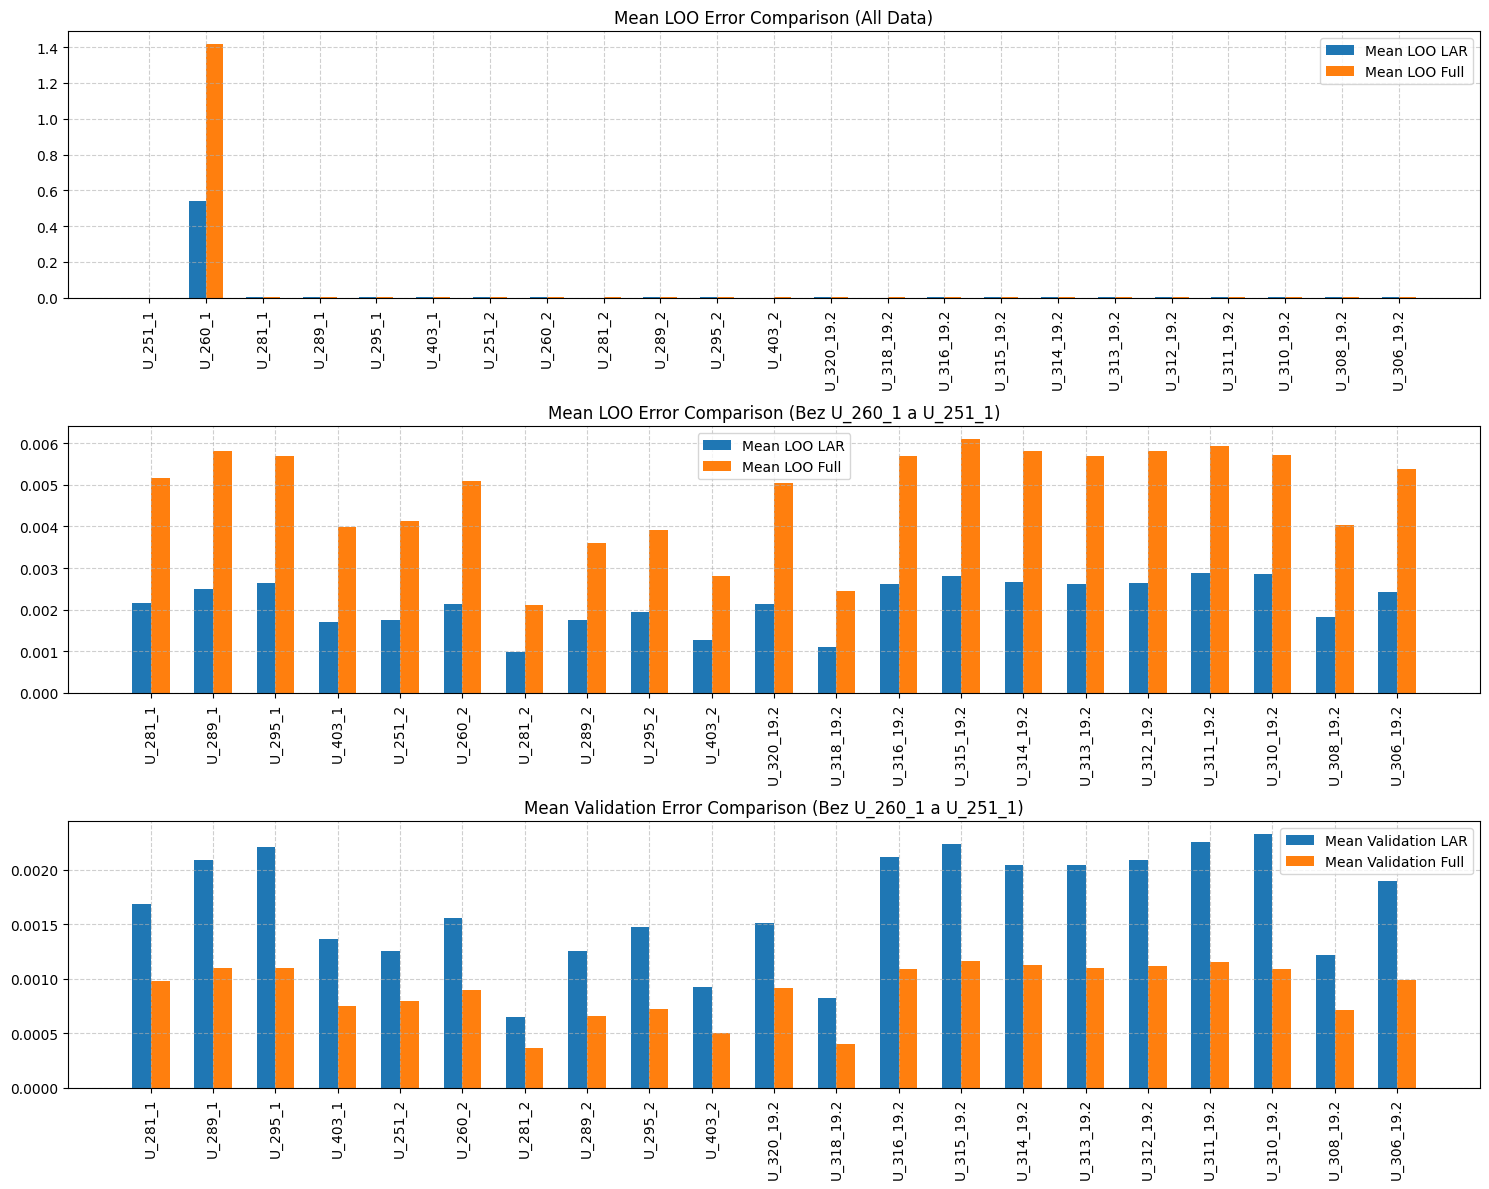

In [50]:
n_sim = nsim
n_cols = len(df_u.columns)
n_runs = 2

all_results = []
all_best_errors = []
all_best_val_errors = []
all_best_means = []
all_best_stds = []
all_sobol_first = []
all_sobol_total = []

for run in range(n_runs):
    print(f"\n Pruchod {run+1}/{n_runs}")
    
    # Randomly sample n_sim indices without replacement
    random_indices = random.sample(range(len(df_params)), n_sim)
    X = df_params.iloc[random_indices].values
    Y = df_u.iloc[random_indices].values
    
    # Inicializace
    best_error = np.full(n_cols, np.nan)
    best_val_error = np.full(n_cols, np.nan)
    best_mean = np.full(n_cols, np.nan)
    best_std = np.full(n_cols, np.nan)
    best_params = [None] * n_cols
    sobol_first = [None] * n_cols
    sobol_total = [None] * n_cols
    
    # LAR vs Full PCE
    err_lar = np.full(n_cols, np.nan)
    err_full = np.full(n_cols, np.nan)
    val_lar = np.full(n_cols, np.nan)
    val_full = np.full(n_cols, np.nan)

    for i, col in enumerate(df_u.columns):
        Y_col = Y[:, i].reshape(-1, 1)  

        # Improved constant output detection
        if np.allclose(Y_col, Y_col[0], atol=1e-12):
            best_params[i] = (1, 1.0)
            best_error[i] = best_val_error[i] = 0.0
            best_mean[i] = float(Y_col[0])
            best_std[i] = 0.0
            sobol_first[i] = sobol_total[i] = np.zeros(X.shape[1])
            err_lar[i] = 0.0
            err_full[i] = 0.0
            val_lar[i] = 0.0
            val_full[i] = 0.0
            continue

        best_err = np.inf
        best_model = None

        for p in range(3, 4):
            for q in [0.6, 0.8, 1.0]:
                try:
                    basis = TotalDegreeBasis(joint, p, hyperbolic=q)
                    
                    if basis.polynomials_number >= 0.9 * len(X):
                        continue

                    pce = PolynomialChaosExpansion(polynomial_basis=basis, regression_method=least_squares)
                    pce.fit(X, Y_col)

                    # LAR regression
                    try:
                        from UQpy.surrogates.polynomial_chaos.regressions import LeastAngleRegression
                        lar = LeastAngleRegression.model_selection(pce, target_error, CheckOverfitting)
                        e_lar = lar.leaveoneout_error()
                        v_lar = lar.validation_error(X, Y_col)
                    except:
                        e_lar = np.inf; v_lar = np.inf

                    # Full PCE
                    try:
                        e_full = pce.leaveoneout_error()
                        v_full = pce.validation_error(X, Y_col)
                    except:
                        e_full = np.inf; v_full = np.inf

                    # 
                    err_lar[i] = e_lar if np.isfinite(e_lar) else np.nan
                    err_full[i] = e_full if np.isfinite(e_full) else np.nan
                    val_lar[i] = v_lar if np.isfinite(v_lar) else np.nan
                    val_full[i] = v_full if np.isfinite(v_full) else np.nan

                    # Vybrani lepsiho
                    chosen, e = (lar, e_lar) if e_lar < e_full else (pce, e_full)
                    if np.isfinite(e) and e < best_err:
                        best_err = e
                        best_model = chosen
                        best_params[i] = (p, q)
                        best_error[i] = e
                        best_val_error[i] = v_lar if chosen is lar else v_full

                except Exception as exc:
                    print(f"  Error p={p}, q={q} → {exc}")
                    continue

        if best_model is not None:
            m, v = best_model.get_moments()
            best_mean[i] = float(m)
            best_std[i] = float(np.sqrt(v))
            sens = PceSensitivity(best_model); sens.run()
            sobol_first[i] = sens.first_order_indices
            sobol_total[i] = sens.total_order_indices
        else:
            print(f"⚠️ No stable model found for {col}.")

    
    run_results = pd.DataFrame({
        'column': df_u.columns,
        'p': [bp[0] if bp else None for bp in best_params],
        'q': [bp[1] if bp else None for bp in best_params],
        'LOO_best': best_error,
        'Val_best': best_val_error,
        'mean_PCE': best_mean,
        'std_PCE': best_std,
        'LOO_LAR': err_lar,
        'LOO_full': err_full,
        'Val_LAR': val_lar,
        'Val_full': val_full
    })
    
    all_results.append(run_results)
    all_best_errors.append(best_error)
    all_best_val_errors.append(best_val_error)
    all_best_means.append(best_mean)
    all_best_stds.append(best_std)
    all_sobol_first.append(sobol_first)
    all_sobol_total.append(sobol_total)

#Nejlepsi Mean
mean_results = pd.DataFrame({
    'column': df_u.columns,
    'mean_LOO_best': np.nanmean([r['LOO_best'].values for r in all_results], axis=0),
    'mean_Val_best': np.nanmean([r['Val_best'].values for r in all_results], axis=0),
    'mean_mean_PCE': np.nanmean([r['mean_PCE'].values for r in all_results], axis=0),
    'mean_std_PCE': np.nanmean([r['std_PCE'].values for r in all_results], axis=0),
    'mean_LOO_LAR': np.nanmean([r['LOO_LAR'].values for r in all_results], axis=0),
    'mean_LOO_full': np.nanmean([r['LOO_full'].values for r in all_results], axis=0),
    'mean_Val_LAR': np.nanmean([r['Val_LAR'].values for r in all_results], axis=0),
    'mean_Val_full': np.nanmean([r['Val_full'].values for r in all_results], axis=0),
})

print("\n Mean results ")
print(mean_results)

plt.figure(figsize=(15, 12))

# --- Plot 1: All data (LOO errors only) ---
plt.subplot(3, 1, 1)
x_all = np.arange(n_cols)
w = 0.3
plt.bar(x_all - w/2, mean_results['mean_LOO_LAR'], w, label='Mean LOO LAR')
plt.bar(x_all + w/2, mean_results['mean_LOO_full'], w, label='Mean LOO Full')
plt.xticks(x_all, df_u.columns, rotation=90)
plt.title('Mean LOO Error Comparison (All Data)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Exclude both U_260_1 and U_251_1
valid_cols = [col for col in df_u.columns if col not in ['U_260_1', 'U_251_1']]
valid_indices = [i for i, col in enumerate(df_u.columns) if col not in ['U_260_1', 'U_251_1']]
x_filtered = np.arange(len(valid_cols))

plt.subplot(3, 1, 2)
plt.bar(x_filtered - w/2, mean_results['mean_LOO_LAR'][valid_indices], w, label='Mean LOO LAR')
plt.bar(x_filtered + w/2, mean_results['mean_LOO_full'][valid_indices], w, label='Mean LOO Full')
plt.xticks(x_filtered, valid_cols, rotation=90)
plt.title('Mean LOO Error Comparison (Bez U_260_1 a U_251_1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot 3: Excluding U_260_1 and U_251_1 (Validation errors) ---
plt.subplot(3, 1, 3)
plt.bar(x_filtered - w/2, mean_results['mean_Val_LAR'][valid_indices], w, label='Mean Validation LAR')
plt.bar(x_filtered + w/2, mean_results['mean_Val_full'][valid_indices], w, label='Mean Validation Full')
plt.xticks(x_filtered, valid_cols, rotation=90)
plt.title('Mean Validation Error Comparison (Bez U_260_1 a U_251_1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


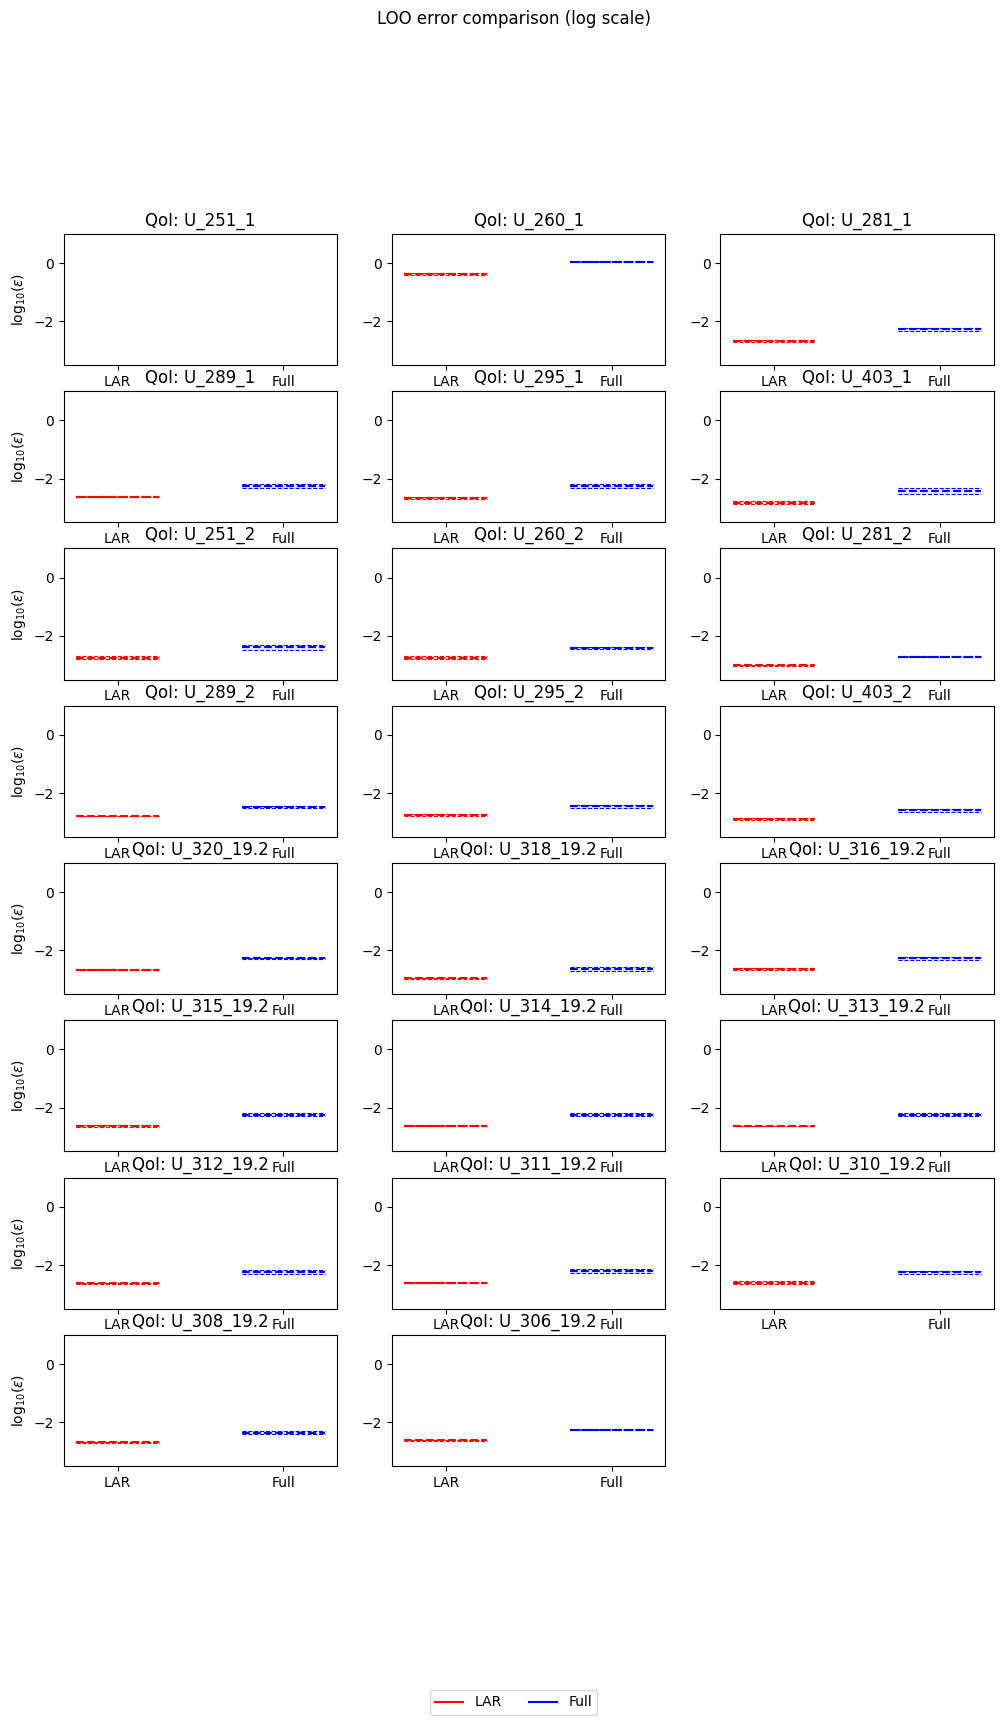

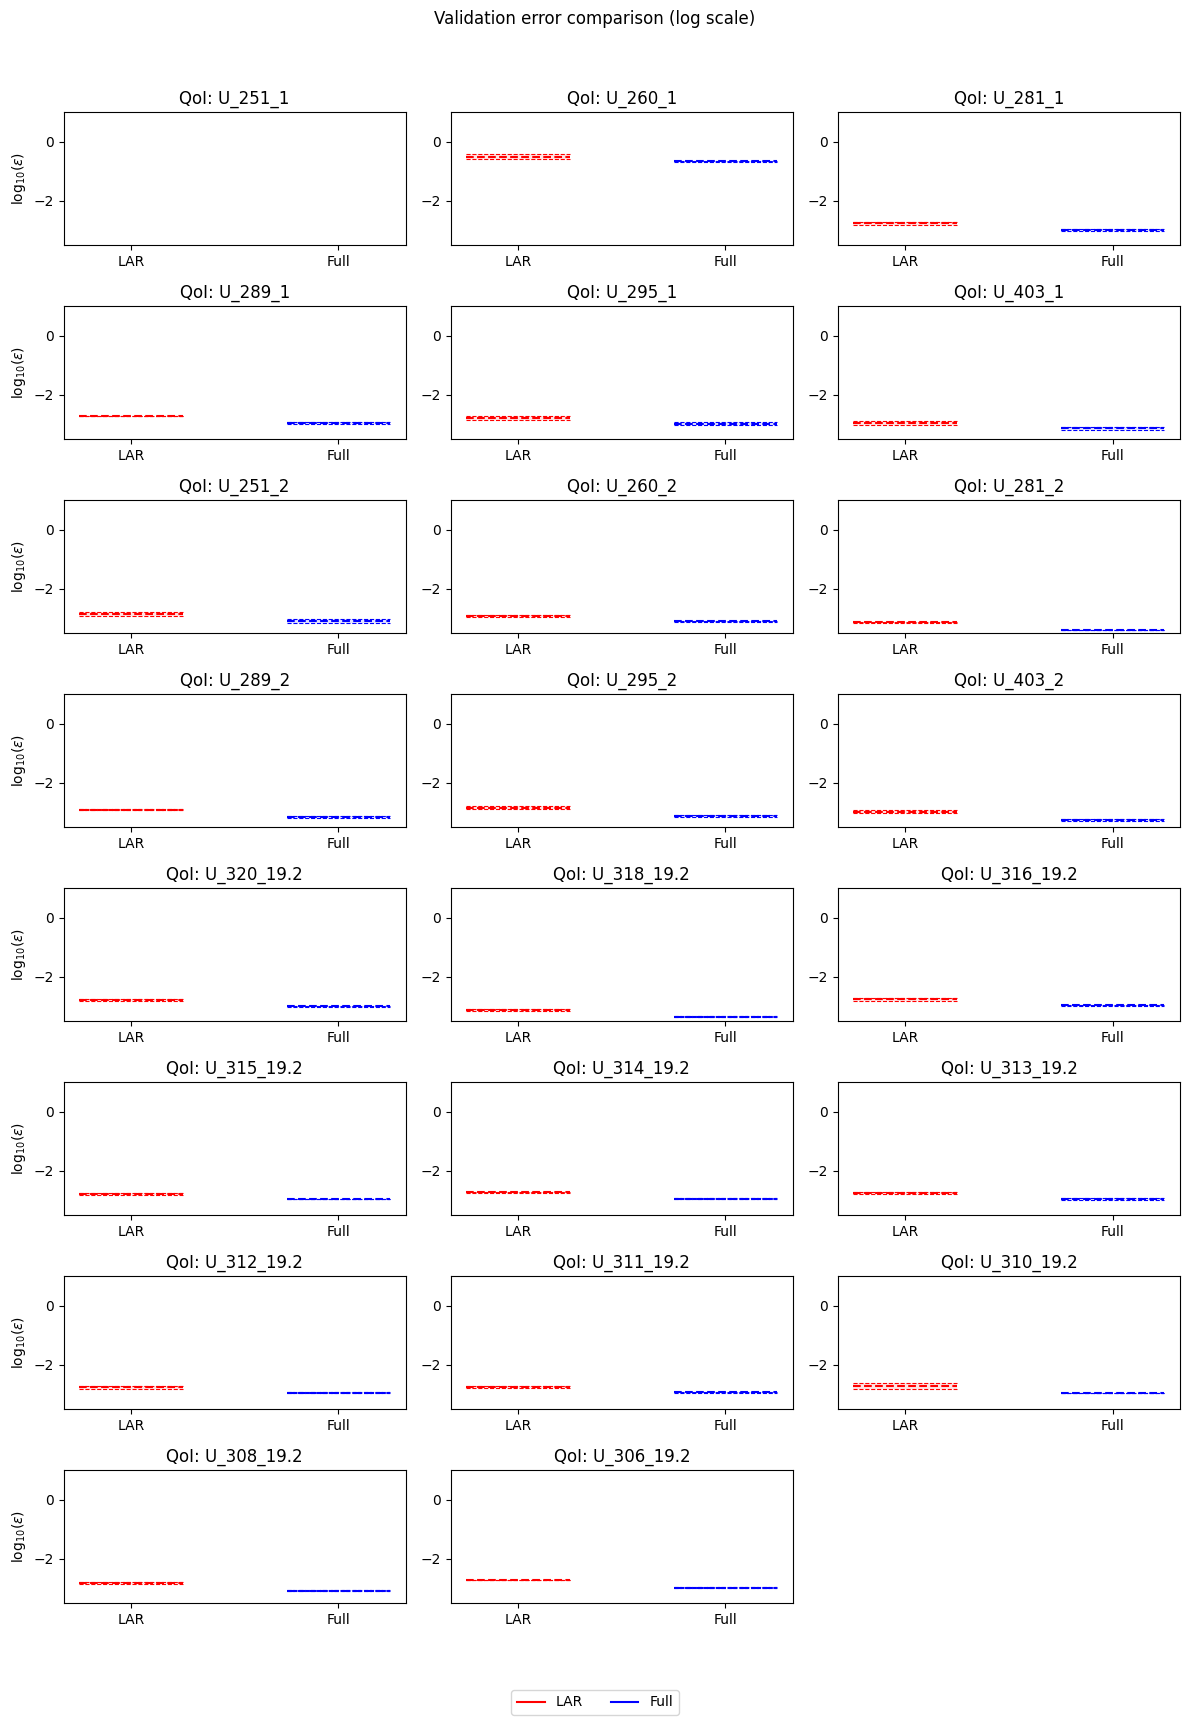

In [48]:
# PCE LAR x Full chyba vykresleni
def logplot(vals):
    vals = np.log10(vals)
    delta = np.std(np.array(vals))
    means = np.mean(np.array(vals))
    maxy = means + delta
    miny = means - delta
    if means < -10:
        means = -10
        maxy = -10
        miny = -10
    return means, maxy, miny
n_runs = len(all_results)
n_cols = len(df_u.columns)

# Vezme vsechny errory
lar_loo_errors = np.array([r['LOO_LAR'].values for r in all_results])
full_loo_errors = np.array([r['LOO_full'].values for r in all_results])
lar_val_errors = np.array([r['Val_LAR'].values for r in all_results])
full_val_errors = np.array([r['Val_full'].values for r in all_results])

#LOO errors
fig_loo, axes_loo = plt.subplots(8, 3, figsize=(12, 16))
fig_loo.suptitle('LOO error comparison (log scale)', y=1.02)

# Validation errors
fig_val, axes_val = plt.subplots(8, 3, figsize=(12, 16))
fig_val.suptitle('Validation error comparison (log scale)', y=1.02)
axes_loo = axes_loo.flatten()
axes_val = axes_val.flatten()

for j, col in enumerate(df_u.columns):
    if j >= len(axes_loo):
        break
    # QoI
    lar_loo = lar_loo_errors[:, j]
    full_loo = full_loo_errors[:, j]
    lar_val = lar_val_errors[:, j]
    full_val = full_val_errors[:, j]
    # Calculate logplot values
    lar_loo_mean, lar_loo_max, lar_loo_min = logplot(lar_loo)
    full_loo_mean, full_loo_max, full_loo_min = logplot(full_loo)
    lar_val_mean, lar_val_max, lar_val_min = logplot(lar_val)
    full_val_mean, full_val_max, full_val_min = logplot(full_val)
    
    # LOO Error Plot
    ax_loo = axes_loo[j]
    ax_loo.set_title(f'QoI: {col}')
    ax_loo.set_ylim(-3.5, 1)
    
    #LAR
    ax_loo.plot([1, 2], [lar_loo_mean, lar_loo_mean], '--', c='red', label='LAR')
    ax_loo.plot([1, 2], [lar_loo_min, lar_loo_min], '--', c='red', linewidth=0.8)
    ax_loo.plot([1, 2], [lar_loo_max, lar_loo_max], '--', c='red', linewidth=0.8)
    ax_loo.fill_between([1, 2], lar_loo_min, lar_loo_max, facecolor=(1, 0, 0, 0.1))
    # Full
    ax_loo.plot([3, 4], [full_loo_mean, full_loo_mean], '--', c='blue', label='Full')
    ax_loo.plot([3, 4], [full_loo_min, full_loo_min], '--', c='blue', linewidth=0.8)
    ax_loo.plot([3, 4], [full_loo_max, full_loo_max], '--', c='blue', linewidth=0.8)
    ax_loo.fill_between([3, 4], full_loo_min, full_loo_max, facecolor=(0, 0, 1, 0.1))
    
    ax_loo.set_xticks([1.5, 3.5])
    ax_loo.set_xticklabels(['LAR', 'Full'])
    if j % 3 == 0:
        ax_loo.set_ylabel('log$_{10}$($\epsilon$)')
  
    ax_val = axes_val[j]
    ax_val.set_title(f'QoI: {col}')
    ax_val.set_ylim(-3.5, 1)
    
    # LAR
    ax_val.plot([1, 2], [lar_val_mean, lar_val_mean], '--', c='red', label='LAR')
    ax_val.plot([1, 2], [lar_val_min, lar_val_min], '--', c='red', linewidth=0.8)
    ax_val.plot([1, 2], [lar_val_max, lar_val_max], '--', c='red', linewidth=0.8)
    ax_val.fill_between([1, 2], lar_val_min, lar_val_max, facecolor=(1, 0, 0, 0.1))
    
    # Full
    ax_val.plot([3, 4], [full_val_mean, full_val_mean], '--', c='blue', label='Full')
    ax_val.plot([3, 4], [full_val_min, full_val_min], '--', c='blue', linewidth=0.8)
    ax_val.plot([3, 4], [full_val_max, full_val_max], '--', c='blue', linewidth=0.8)
    ax_val.fill_between([3, 4], full_val_min, full_val_max, facecolor=(0, 0, 1, 0.1))
    
    ax_val.set_xticks([1.5, 3.5])
    ax_val.set_xticklabels(['LAR', 'Full'])
    if j % 3 == 0:
        ax_val.set_ylabel('log$_{10}$($\epsilon$)')

for j in range(len(df_u.columns), len(axes_loo)):
    fig_loo.delaxes(axes_loo[j])
    fig_val.delaxes(axes_val[j])
handles = [plt.Line2D([0], [0], color='red', label='LAR'),
           plt.Line2D([0], [0], color='blue', label='Full')]
fig_loo.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
fig_val.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()


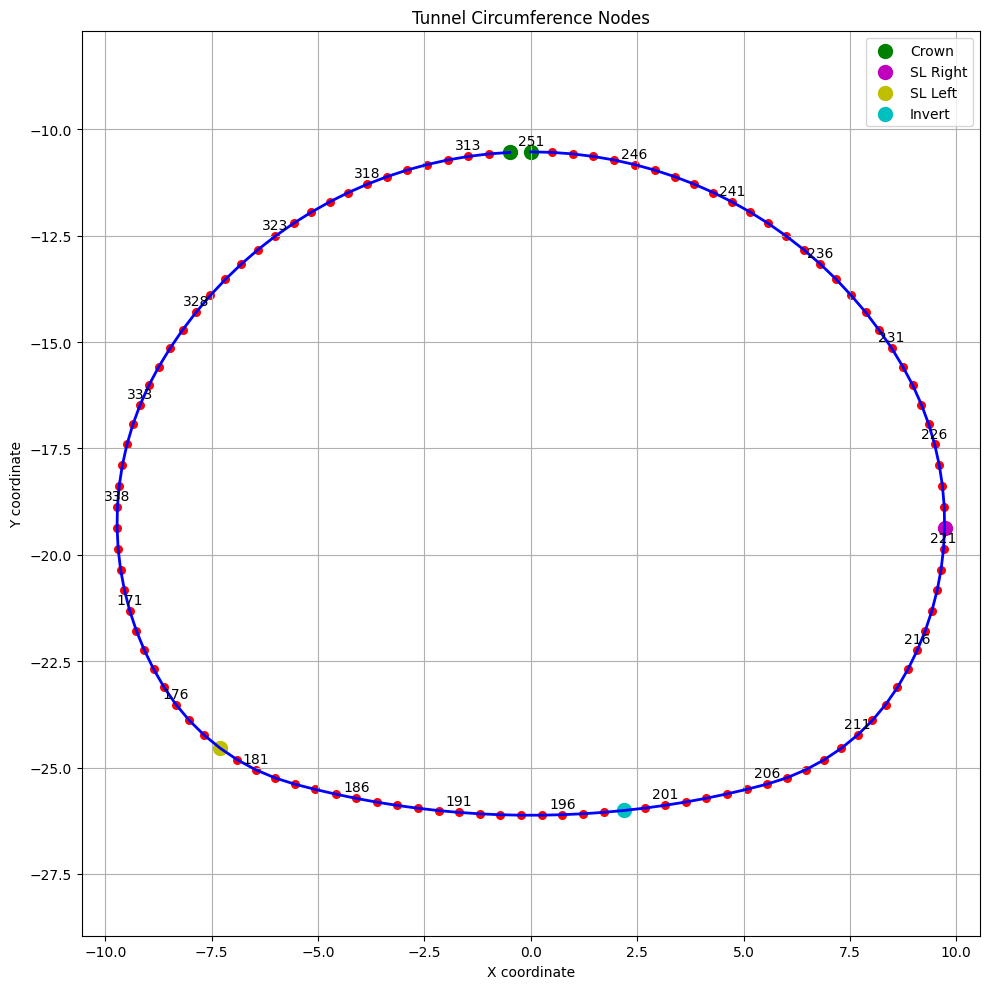

In [27]:
#vykresleni
nodes = [
    (0, -10.5275), (0.492, -10.5395), (0.983, -10.5755), (1.4719, -10.6353),
    (1.95708, -10.719), (2.43761, -10.8261), (2.91235, -10.9566), (3.38016, -11.1101),
    (3.83994, -11.2861), (4.29059, -11.4844), (4.73104, -11.7044), (5.16024, -11.9456),
    (5.57717, -12.2075), (6.00215, -12.505), (6.41129, -12.824), (6.80351, -13.1636),
    (7.17776, -13.5229), (7.53, -13.901), (7.87, -14.2968), (8.18, -14.7093),
    (8.48, -15.1374), (8.74685, -15.58), (8.97931, -16.0164), (9.18182, -16.4675),
    (9.35346, -16.9312), (9.49344, -17.4055), (9.60113, -17.8881), (9.67604, -18.3768),
    (9.71783, -18.8695), (9.7263, -19.3639), (9.70142, -19.8578), (9.64331, -20.3488),
    (9.55222, -20.8348), (9.42857, -21.3136), (9.27246, -21.7842), (9.08488, -22.2431),
    (8.86671, -22.6884), (8.61894, -23.1179), (8.34143, -23.5199), (8.02741, -23.8942),
    (7.67966, -24.2374), (7.30124, -24.5464), (6.89548, -24.8185), (6.46599, -25.0513),
    (6.01653, -25.2428), (5.55109, -25.3913), (5.07787, -25.5123), (4.60202, -25.6225),
    (4.12377, -25.7219), (3.6434, -25.8104), (3.16338, -25.8875), (2.68174, -25.9538),
    (2.19873, -26.0091), (1.71458, -26.0534), (1.22955, -26.0868), (0.744, -26.1092),
    (0.258, -26.1205), (-0.228, -26.1209), (-0.714, -26.1102), (-1.20007, -26.0885),
    (-1.68514, -26.0558), (-2.16935, -26.0121), (-2.65244, -25.9574), (-3.13417, -25.8919),
    (-3.61429, -25.8154), (-4.10204, -25.7262), (-4.58759, -25.6257), (-5.07, -25.5141),
    (-5.55, -25.3913), (-6.01653, -25.2428), (-6.47, -25.0513), (-6.90, -24.8185),
    (-7.30124, -24.5464), (-7.67966, -24.2374), (-8.02741, -23.8942), (-8.34143, -23.5199),
    (-8.61894, -23.1179), (-8.86671, -22.6884), (-9.08488, -22.2431), (-9.27246, -21.7842),
    (-9.42857, -21.3136), (-9.55222, -20.8348), (-9.64331, -20.3488), (-9.70142, -19.8578),
    (-9.7263, -19.3639), (-9.71783, -18.8695), (-9.67604, -18.3768), (-9.60113, -17.8881),
    (-9.49344, -17.4055), (-9.35346, -16.9312), (-9.18182, -16.4675), (-8.97931, -16.0164),
    (-8.74685, -15.58), (-8.47618, -15.1374), (-8.18314, -14.7093), (-7.86849, -14.2968),
    (-7.53307, -13.901), (-7.17776, -13.5229), (-6.80351, -13.1636), (-6.41129, -12.824),
    (-6.00215, -12.505), (-5.57717, -12.2075), (-5.16024, -11.9456), (-4.73104, -11.7044),
    (-4.29059, -11.4844), (-3.83994, -11.2861), (-3.38016, -11.1101), (-2.91235, -10.9566),
    (-2.43761, -10.8261), (-1.95708, -10.719), (-1.4719, -10.6353), (-0.983, -10.5755),
    (-0.492, -10.5395)
]

x = [point[0] for point in nodes]
y = [point[1] for point in nodes]
plt.figure(figsize=(10, 10))
plt.plot(x, y, 'b-', linewidth=2)  # Connect all points with a blue line
plt.scatter(x, y, c='r', s=30)   

# Hspecial points
crown_nodes = [nodes[0], nodes[-1]]
sl_right = nodes[29]
sl_left = nodes[72]
invert = nodes[52]
plt.scatter([p[0] for p in crown_nodes], [p[1] for p in crown_nodes], c='g', s=100, label='Crown')
plt.scatter(sl_right[0], sl_right[1], c='m', s=100, label='SL Right')
plt.scatter(sl_left[0], sl_left[1], c='y', s=100, label='SL Left')
plt.scatter(invert[0], invert[1], c='c', s=100, label='Invert')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Tunnel Circumference Nodes')
plt.grid(True)
plt.axis('equal') 
plt.legend()
for i, (xi, yi) in enumerate(nodes):
    if i % 5 == 0: 
        plt.annotate(str(251-i if i <= 83 else 251-i+172), (xi, yi), textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()